<h1 style="font-size:40px;"><center>Exercise I:<br> Backpropagation in Numpy
</center></h1>


Welcome to the first lab for Deep Learning!

In this lab we will scratch the surface of deep learning. For the first part of this lab we are going to introduce the concept of deep learning. For this lab we will perform and train a network with the help of Numpy to get an idea of how a neural network works.

For this lab all tasks include **TODO's** these are expected to be done before the deadline. At the end of the lab some questions shall be answered and what you have learned during the lab. To give a hand if the answer is correct a few asserts and expected results are given. Some sections does not contain any **TODO's** but is good to understand them.


Good luck!

---

## Neuron
A neuron is a part of a neural network and in it simplest form we can define it as a perceptron. A perceptron can solve binary problems based on $x_{p}$ number of inputs. In other words, problems that can be solved with a linear function.

The math for the perceptron or a single neuron are defined as; $y(x,w) = p_{0}(\sum_{k=1}^{P} w_{k}x_{k} + w_{0}) = \sum_{k=0}^{P} w_{k}x_{k} = p_{0}(w^{T}x)$ where $p_{0}$ is an activation function to introduce non-linearity into the output of a neuron. For the image below the concept of bias is used and corresponds to $w_{0}$ in the equation above.

<center>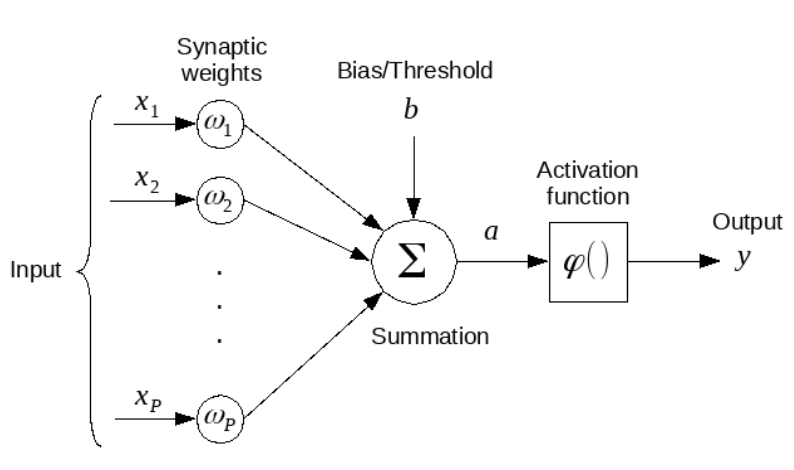</center>

## MLP
In order to extend from a binary problem we can define a multi-layer perceptron (MLP) that consist of at least one one hidden layer. Each layer can in turn consist of multiple neurons. 

In this lab we will create a Feedforward Multilayer network. This will consist of a backpropagation algorithm (SGD with the chain rule) which allow us to calculate partial derivatives in terms of other partial derivatives. The backpropagation algorithm will use sigmoid activation function (binary) between the layers and the final layer to classification uses softmax (multi-class).
<center><img src="../data/images/MLP.PNG" width="600"></center>


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torchvision
import torch

# Load dataset
The first step is to import the dataset. We will focus on the digits dataset from sklearn.

In [2]:
digits = load_digits()

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15, random_state=37)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

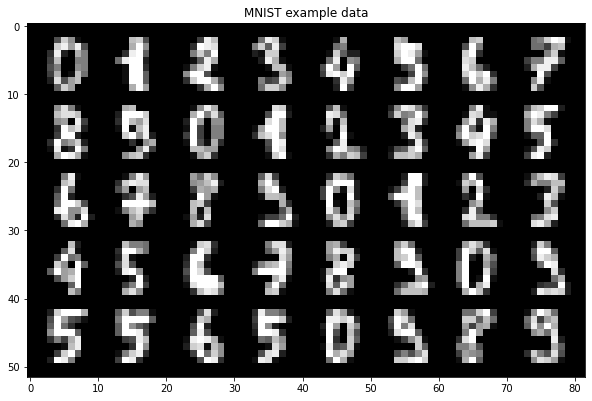

In [3]:
sample_index = 40
plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(digits.images[:sample_index]).unsqueeze(1), normalize=True).permute(1,2,0),cmap=plt.cm.gray_r,interpolation='nearest')
plt.title("MNIST example data");

## Predefined settings
Here we define some settings that we will use later. 

* EPSILON: To avoid instability if probability equals 0. 
* INPUT_SIZE: Define the shape of our input.
* HIDDEN_SIZE: Number of neurons in the hidden layer.
* OUTPUT_SIZE: Number of classes for calculate probability.

In [4]:
# Creating data set
EPSILON = 1e-6
INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZE = 10
OUTPUT_SIZE = len(np.unique(y_train))

## One-hot encoding
To differentiate between the classes from the dataset we one-hot encode the labels based on the unique length of the labels.

In [5]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

## Activation function
First task is to define the activation functions. Below is three function that should be implemented. Verify the output based on the given input.

1. **TODO:** Implement sigmoid 
2. **TODO:** Implement dsigmoid which is the element-wise derivitate of sigmoid 
3. **TODO:** Implement softmax 

$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$

$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$

$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$

In [6]:
def sigmoid(x):
    #TODO
    return 1/(1 + np.exp(-x))

In [7]:
def dsigmoid(X):
    #TODO
    sig=sigmoid(X)
    return sig * (1 - sig)

In [8]:
def softmax(X):
    #TODO
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

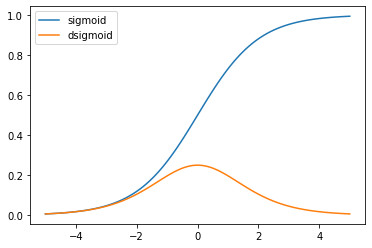

In [9]:
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

### Expected result - sigmoid and dsigmoid
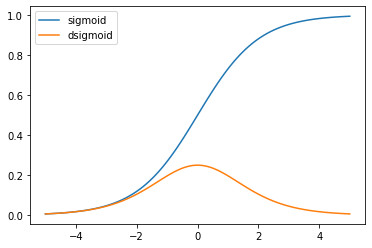


### Test Softmax

In [10]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])

assert np.allclose(softmax([10, 2, -3]), [9.99662391e-01, 3.35349373e-04, 2.25956630e-06]), "Wrong answer!"
assert np.allclose(softmax(X),[[9.99662391e-01, 3.35349373e-04, 2.25956630e-06],[2.47262316e-03, 9.97527377e-01, 1.38536042e-11]]), "Wrong answer!"
assert (np.sum(softmax(X), axis=1) == [1,1]).all(), "Probability not equal to 1"

## Loss function.


**TODO:** Implement the negative log likelihood defined as:
$C=−\frac{1}{n}\sum_{x}^{n}(lna_{y}^{L})$

In [11]:
def nll(Y_true, Y_pred):
    #TODO
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

### Test nll

In [12]:
assert nll([1, 0, 0], [.99, 0.01, 0]) == 0.010049325753001472, "Wrong output!"

In [13]:
Y_true = np.array([[0, 1, 0],[1, 0, 0],[0, 0, 1]])

Y_pred = np.array([[0, 1, 0],[.99, 0.01, 0], [0, 0, 1]])

assert nll(Y_true, Y_pred) == 0.0033491085846672117

## Feedforward
The feedforward function is defined with two things; 

* $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
* $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

The hidden layer will use sigmoid as activation function but for final classification we will use softmax.
In case we want to observe the activations we can enable **keep_activations**. If enabled, return; y,h,z_h otherwise return y.

**TODO:** Implement **h** and **y**

In [70]:
def forward(X, keep_activations=False):
    z_h = np.dot(X, W_h) + b_h
    h = sigmoid(z_h)
    z_o = np.dot(h, W_o) + b_o
    y = softmax(z_o)
    if keep_activations:
        return y, h, z_h
    else:
        return y

## Init weights
Random init of weights $W$. To help the architecture we can define random initiation of weights. 

* W_h: Weights for the hidden layer 
* b_h: Bias for the hidden layer 
* W_o: Weight for the output 
* b_o: Bias for the output

In [16]:
W_h = np.random.uniform(size=(INPUT_SIZE, HIDDEN_SIZE), high=0.01, low=-0.01)
b_h = np.zeros(HIDDEN_SIZE)
W_o = np.random.uniform(size=(HIDDEN_SIZE, OUTPUT_SIZE), high=0.01, low=-0.01)
b_o = np.zeros(OUTPUT_SIZE)

## Backpropagation
Calculate the gradient loss $\frac{d}{dW} -\log(softmax(W \dot x + b))$. Where x is the input and y is the truth values.

**TODO:** Implement the gradient loss function for; 
* grad_W_h - Weight gradient of hidden layer
* grad_W_o - Weight gradient of output layer
* grad_b_h - Bias gradient of hidden layer
* grad_b_o - Bias gradient of output layer

In [17]:
def grad_loss(x, y_true):
    y, h, z_h = forward(x, keep_activations=True)
    grad_z_o = y - one_hot(OUTPUT_SIZE, y_true)

    grad_W_o = np.outer(h, grad_z_o)
    grad_b_o = grad_z_o
    grad_h = np.dot(grad_z_o, np.transpose(W_o))
    grad_z_h = grad_h * dsigmoid(z_h)
    grad_W_h = np.outer(x, grad_z_h)
    grad_b_h = grad_z_h
    grads = {"W_h": grad_W_h, "b_h": grad_b_h,
             "W_o": grad_W_o, "b_o": grad_b_o}
    return grads

## SGD
Uses the grad function output to update $W$ and $b$

**TODO:** Implement SGD to update the weights provided from **grad_loss function** with $w = w-\eta \nabla Q(w)$ where Q(w) is the loss function, $\eta$ is the learning rate and $w$ is the weight.

In [18]:
def SGD(x, y, learning_rate):
    grads = grad_loss(x, y)
    W_h = W_h - learning_rate * grads["W_h"]
    b_h = b_h - learning_rate * grads["b_h"]
    W_o = W_o - learning_rate * grads["W_o"]
    b_o = b_o - learning_rate * grads["b_o"]

## Loss
Combine the nll with one-hot encoding and the predicted value from the the forward function to test the implementation.

In [93]:
def loss(X, y):
    return nll(one_hot(OUTPUT_SIZE, y), forward(X))

## Predict
To predict we calculate the indices of the maximum values along an axis. on the forward pass. However we need to consider if the input is 1D (one input) or 2D (multiple inputs). We therefore check if len(X.shape) == 1, otherwise we extract the indices of the maximum values along axis=1.

In [20]:
def predict(X):
    return np.argmax(self.forward(X)) if len(X.shape) == 1 else np.argmax(self.forward(X), axis=1)

## Metric
To evaluate the network we are going to use accuracy.

In [32]:
def accuracy(y_preds, y_truth):
    return np.mean(y_preds == y_truth)

## Neural network
Now to combine all previous steps into this class. Note that the function should now include **self** to access the internal memory of the weights.

In [61]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size

    def forward(self, X, keep_activations=False):
        #TODO
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        if keep_activations:
            return y, h, z_h
        else:
            return y

    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        #TODO
        y, h, z_h = self.forward(x, keep_activations=True)
        grad_z_o = y - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        grads = {"W_h": grad_W_h, "b_h": grad_b_h,
                 "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def SGD(self, x, y, learning_rate):
        # Traditional SGD update on one sample at a time
        #TODO
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        return np.argmax(self.forward(X)) if len(X.shape) == 1 else np.argmax(self.forward(X), axis=1)

In [62]:
model = NeuralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

In [63]:
losses, accuracies, accuracies_test = [loss(X_train, y_train)], [accuracy(X_train, y_train)], [accuracy(X_test, y_test)]

print(f"Random init: train loss: {losses[-1]:0.5f}, train acc: {accuracies[-1]:0.3f}, test acc: {accuracies_test[-1]:0.3f}")

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.SGD(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(accuracy(model.predict(X_train),y_train))
    accuracies_test.append(accuracy(model.predict(X_test),y_test))
    
    print(f"Epoch {epoch:d}, train loss: {losses[-1]:0.5f}, train acc: {accuracies[-1]:0.3f}, test acc: {accuracies_test[-1]:0.3f}", end="\r")

<ipython-input-32-af0353f585f6>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.mean(y_preds == y_truth)


Random init: train loss: 269.58567, train acc: 0.000, test acc: 0.000


## Visualize the result

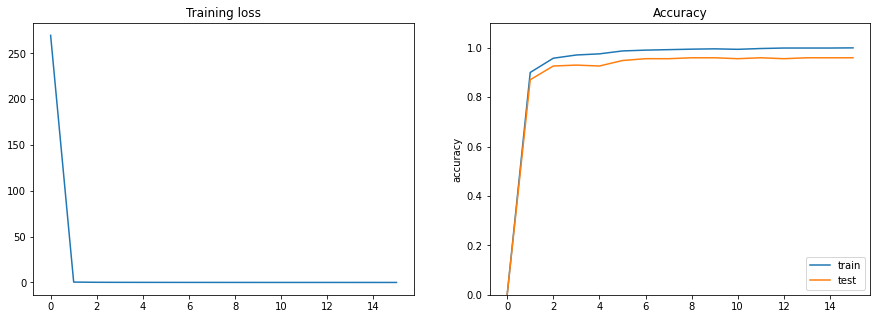

In [92]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.plot(losses)
ax0.set_title("Training loss");

ax1.plot(accuracies, label='train')
ax1.plot(accuracies_test, label='test')
ax1.set_ylim(0, 1.1)
ax1.set_ylabel("accuracy")
ax1.legend(loc='best');
ax1.set_title("Accuracy");

## Expected result
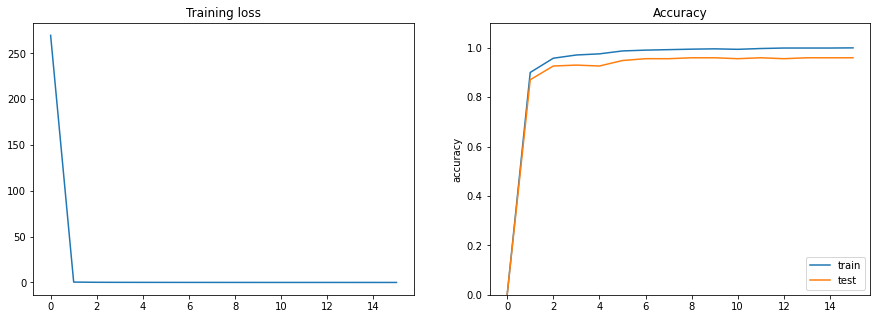
